In [1]:
!pip install -U sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str, num_purchases_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        num_purchases = torch.tensor([float(v) for v in num_purchases_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, num_purchases)
        
        target = target / target.sum()  # Normalise

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str, example_age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age),
            float(example_age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age, num_purchases, example_age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age, example_age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label, num_purchases)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [8]:
articles_df = pd.read_csv('data/articles_df_filt_with_counts_and_age_extended.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(48726, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt_with_counts_and_age_extended.csv')
print(customers.shape)
customers.head()

(52787, 5)


,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


### Create article EmbeddingBag

In [10]:
model = SentenceTransformer('all-distilroberta-v1')

In [11]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [12]:
model.encode(article_descriptions[0]).shape

(768,)

In [13]:
embeddings = model.encode(article_descriptions)

In [14]:
embeddings = torch.tensor(embeddings)

In [15]:
embeddings.shape

torch.Size([48726, 768])

In [16]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [17]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+768+4, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [18]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [19]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(52787, 384)
  (fc_1): Linear(in_features=1156, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=48726, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [20]:
BATCH_SIZE = 1024

In [21]:
total_training_examples = pd.read_csv('data/final_train_set_with_counts_and_age_extended.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

52.0

In [22]:
total_dev_examples = pd.read_csv('data/final_dev_set_with_counts_and_age_extended.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

10.0

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)

200 epochs

LR: 0.001 -> 0.0001 @ 100 epochs

In [115]:
MAX_EPOCHS = 100

training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age_extended_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
    
    if ((epoch + 1) % 50 == 0) | epoch == 0:

        # Compute train loss:
        
        total_train_loss = 0

        fashion_rec_v3.eval()
        
        train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age_extended_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
        
        with torch.no_grad():
            for data in tqdm(train_loader, total=total_batches):

                customer_id_idx, inputs, label = data
                customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

                optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

                y_pred = fashion_rec_v3(customer_id_idx, inputs)

                loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

                total_train_loss += loss.item()

            mean_train_loss = total_train_loss / total_training_examples
            print(f"Training loss: {mean_train_loss}")
            training_losses.append(mean_train_loss)
            
        fashion_rec_v3.train()

100%|██████████| 52/52.0 [00:15<00:00,  3.37it/s]
100%|██████████| 52/52.0 [00:15<00:00,  3.38it/s]


Training loss: 0.9339801202181793


100%|██████████| 10/10.0 [00:03<00:00,  3.31it/s]

Dev loss: 4.8188846257410844


In [116]:
training_losses[-1]

(0.9339801202181793, 4.8188846257410844)

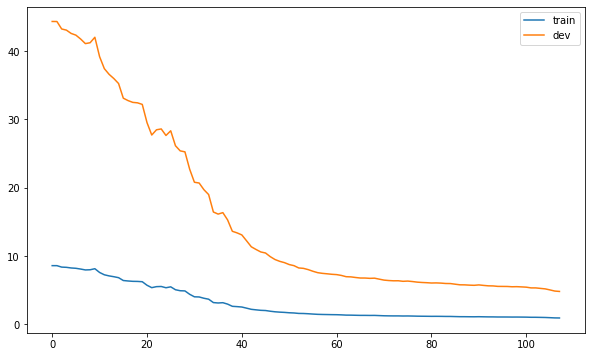

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='train')
plt.legend()
plt.show()

### MAP@12

#### Train

In [118]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age_extended_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 52/52.0 [00:14<00:00,  3.55it/s]


In [119]:
predictions = torch.concat(predictions)

In [120]:
predictions.shape

torch.Size([52787, 1000])

In [121]:
actuals = pd.read_csv('data/final_train_set_with_counts_and_age_extended_for_submission.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

52787

In [122]:
mapk(actuals, predictions.tolist(), 12)

0.9988408639541114

🤯

In [123]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [124]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.9999994587411944

In [125]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [126]:
np.mean(np.array(number_of_positive_examples ) > 0)

1.0

### Submission

In [4]:
total_sub_batches = np.ceil(pd.read_csv('data/final_submission_inputs_with_counts_and_age_extended_for_submission.tsv', sep='\t').shape[0]/BATCH_SIZE)
total_sub_batches

NameError: name 'BATCH_SIZE' is not defined

In [31]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_submission_inputs_with_counts_and_age_extended_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_sub_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 47/47.0 [00:14<00:00,  3.33it/s]


In [32]:
predictions = torch.concat(predictions)

In [33]:
predictions.shape

torch.Size([47128, 12])

In [34]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [35]:
article_idx_to_id = dict(zip(articles_df['article_id_idx'], articles_df['article_id']))

In [36]:
predictions_article_id = [[article_idx_to_id[i] for i in l] for l in predictions.tolist()]
predictions_article_id[0]

['0827487003',
 '0877332001',
 '0900043001',
 '0902229004',
 '0884550002',
 '0907954004',
 '0888028001',
 '0895361002',
 '0712216001',
 '0865073001',
 '0915526001',
 '0880059003']

In [37]:
predictions_strings = [' '.join(l) for l in predictions_article_id]
predictions_strings[0]

'0827487003 0877332001 0900043001 0902229004 0884550002 0907954004 0888028001 0895361002 0712216001 0865073001 0915526001 0880059003'

In [38]:
submission_set_filt = pd.read_csv('data/final_submission_inputs_with_counts_and_age_extended_for_submission.tsv', sep='\t')
print(submission_set_filt.shape)
submission_set_filt.head()

(47128, 6)


,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age
0,0,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33
1,1,"11824,2456,28519,11826,3269,23088,11825,15029,...",0,0.0,0.0,0.29
2,2,"39073,40201,39074,1243,39277,40370,38239,40344...",0,0.0,0.0,0.23
3,3,"39975,18345,38864,35941,38864,35941,32663,3266...",0,1.0,1.0,0.42
4,4,"703,183,2689,4352,1011,38951,37019,37511,4332,546",0,1.0,1.0,0.25


In [39]:
len(predictions_strings)

47128

In [40]:
customer_idx_to_id = dict(zip(customers['customer_id_idx'], customers['customer_id']))

In [41]:
submission_set_filt['customer_id'] = submission_set_filt['customer_id_idx'].map(customer_idx_to_id)

In [42]:
submission_set_filt['prediction_model'] = predictions_strings

In [43]:
submission_set_filt.isnull().sum()

customer_id_idx          0
article_id_idx_last10    0
article_id_idx_label     0
FN                       0
Active                   0
age                      0
customer_id              0
prediction_model         0
dtype: int64

In [44]:
submission_set_filt.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,customer_id,prediction_model
0,0,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0827487003 0877332001 0900043001 0902229004 08...
1,1,"11824,2456,28519,11826,3269,23088,11825,15029,...",0,0.0,0.0,0.29,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0757926001 0640021019 0856440002 0788575004 08...
2,2,"39073,40201,39074,1243,39277,40370,38239,40344...",0,0.0,0.0,0.23,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,0935892001 0902265001 0882900001 0878190003 09...
3,3,"39975,18345,38864,35941,38864,35941,32663,3266...",0,1.0,1.0,0.42,000fb6e772c5d0023892065e659963da90b1866035558e...,0870328003 0786022008 0919273004 0913272003 09...
4,4,"703,183,2689,4352,1011,38951,37019,37511,4332,546",0,1.0,1.0,0.25,0010e8eb18f131e724d6997909af0808adbba057529edb...,0720125007 0791587015 0610776002 0912204001 07...


In [45]:
sample_submission = sample_submission.merge(submission_set_filt[['customer_id', 'prediction_model']], on='customer_id', how='left')
sample_submission.head()

,customer_id,prediction,prediction_model
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,NaN
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,NaN


In [47]:
sample_submission.isnull().sum() / sample_submission.shape[0]

customer_id         0.00000
prediction          0.00000
prediction_model    0.96565
dtype: float64

In [48]:
sample_submission['prediction_model'].fillna(
    '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003',
    inplace=True
)

In [49]:
sample_submission.drop(columns=['prediction'], inplace=True)
sample_submission.rename(columns={'prediction_model': 'prediction'}, inplace=True)

In [50]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0372860002 0610776002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0372860002 0610776002 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0372860002 0610776002 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0372860002 0610776002 04...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0372860002 0610776002 04...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0751471001 0706016001 0372860002 0610776002 04...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0372860002 0610776002 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0372860002 0610776002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0372860002 0610776002 04...


In [51]:
sample_submission.to_csv('data/20220508-fashionrecv3_F.csv', index=False)